# score based model(NCSN)に基づく生成モデル

In [41]:
import numpy as np
import torch
import torch.autograd as autograd
import torch.distributions as distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [7]:
means = torch.tensor([[2.0, 2.0], [-2.0, -2.0]])

cov_mats = torch.Tensor([
    [[ 1.0,  0.0],
     [ 0.0,  1.0]],
    [[ 1.0,  0.0],
     [ 0.0,  1.0]],
])

mixture_weights = torch.tensor([0.6, 0.4])

mixture_dist = distributions.MixtureSameFamily(
    distributions.Categorical(mixture_weights),
    distributions.MultivariateNormal(means, cov_mats)
)

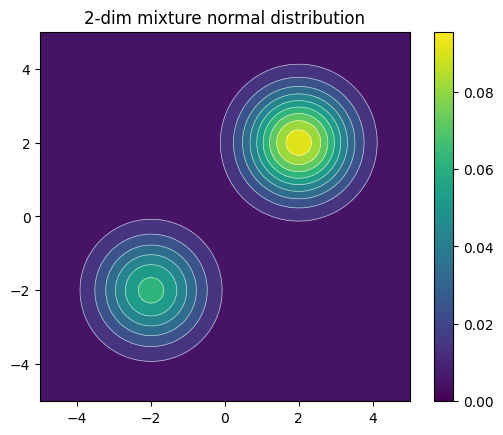

In [12]:
ls = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(ls, ls)
xy_grid = np.stack([X, Y], axis=2)
grid_tensor = torch.from_numpy(xy_grid).float()

probs = torch.exp(mixture_dist.log_prob(grid_tensor))

plt.title('2-dim mixture normal distribution')
plt.pcolormesh(X, Y, probs.reshape(X.shape), cmap='viridis')
plt.colorbar()
contour = plt.contourf(X, Y, probs.numpy(), cmap='viridis', levels=10)
plt.contour(X, Y, probs.numpy(), colors='white', levels=10, linewidths=0.5, alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [74]:
def train(model, dist, device) -> list:
    epoch_num = 100000
    batch_size = 2000
    sigma_scale = 5.0
    loss_list = []
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    model.train()

    for epoch in tqdm(range(epoch_num)):
        optimizer.zero_grad()
        
        samples = dist.sample((batch_size,)).to(device)

        sigma = (sigma_scale * torch.rand(1)).to(device)
        noises = torch.randn_like(samples) * sigma

        samples_tilde = samples + noises

        sigma_batch = sigma.expand(batch_size, 1)
        input_vector = torch.concat([samples_tilde, sigma_batch], axis=1)

        pred_y = model(input_vector)
        target_y = - noises / sigma**2

        loss = (sigma**2 * (torch.linalg.norm(pred_y - target_y, dim=1).mean())).squeeze()

        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            loss_list.append([epoch, loss.item()])

    return loss_list


In [76]:
input_dim = 2
mid1_dim = 12
mid2_dim = 48
mid3_dim = 48
mid4_dim = 12
output_dim = input_dim

model = nn.Sequential(
    nn.Linear(input_dim + 1, mid1_dim),# input_dimはベクトルの次元であり、ネットワークはそれに加えてノイズをインプットに入れる
    nn.ReLU(),
    nn.Linear(mid1_dim, mid2_dim),
    nn.ReLU(),
    nn.Linear(mid2_dim, mid3_dim),
    nn.ReLU(),
    nn.Linear(mid3_dim, mid4_dim),
    nn.ReLU(),
    nn.Linear(mid4_dim, output_dim)
).to(device)

loss_list = train(model, mixture_dist, device)

100%|██████████| 100000/100000 [12:05<00:00, 137.88it/s]


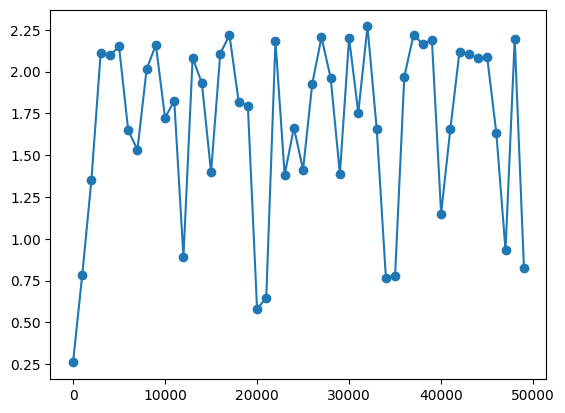

In [65]:
loss_array = np.array(loss_list)

x_coords = loss_array[:, 0]
y_coords = loss_array[:, 1]

plt.plot(x_coords, y_coords, marker="o", linestyle="-")

In [66]:
def model_based_langevin_monte_carlo(model, num_samples, num_steps, step_size, sigma):
    # 初期サンプルを乱数から生成
    input_dim = 2
    x = torch.randn(num_samples, input_dim)
    # モデルを推論モードに変更
    model.eval()
    model.to("cpu")
    # 以下、学習済みモデルによって予測されたスコアを用いてランジュバン・モンテカルロ法を実行
    for i in tqdm(range(num_steps)):
        with torch.no_grad():
            noise = torch.normal(mean=0, std=sigma, size=x.shape)
            noise_x = x + noise
            batch_sigma = torch.ones((noise_x.shape[0], 1)) * sigma
            score = model(torch.concat([noise_x, batch_sigma], axis=1))
            # 最終ステップのみノイズ無しでスコアの方向に更新
            if i < num_steps - 1:
                noise = torch.randn(num_samples, input_dim)
            else:
                noise = 0
            x = x + step_size * score + np.sqrt(2 * step_size) * noise
    model.to(device)
    return x

100%|██████████| 1000/1000 [00:22<00:00, 43.61it/s]


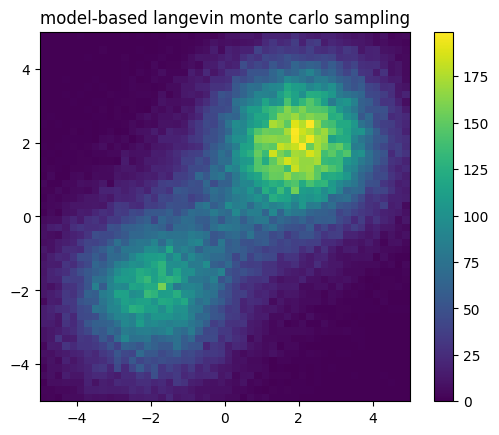

In [77]:
# ランジュバン・モンテカルロ法のパラメータ
num_samples = 100000
num_steps = 1000
step_size = 0.1
sigma = 1

# サンプリングの実行
samples = model_based_langevin_monte_carlo(model, num_samples, num_steps, step_size, sigma)

# サンプリング結果の可視化
plt.title('model-based langevin monte carlo sampling')
plt.hist2d(
    samples[:,0], 
    samples[:,1], 
    range=((-5, 5), (-5, 5)), 
    cmap='viridis', 
    bins=50, 
)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.colorbar()
plt.show()